In [ ]:
# -----------------------------------------------------------
# IMPORT ALL NECESSARY MODULES
# -----------------------------------------------------------

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import gc
from keras.utils.vis_utils import plot_model
from keras.applications.vgg19 import VGG19
from tqdm import tqdm
from PIL import Image
from IPython.display import display, Image
import tensorflow as tf
import pandas as pd
import numpy as np
%matplotlib inline


In [ ]:
# -----------------------------------------------------------
# LOAD THE DATASET AND PLOT THE OBSERVATIONS
# -----------------------------------------------------------

df = pd.read_csv('azure.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()
df.plot(figsize=(16, 8))
plt.show()


In [ ]:
# -----------------------------------------------------------
# CREATE TRAIN-TEST SPLIT (80:20)
# -----------------------------------------------------------
TRAIN_LENGTH = round(len(df)*0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
test = df[TRAIN_LENGTH:]


In [ ]:
# -----------------------------------------------------------
# SCALING VALUES
# -----------------------------------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=df.columns)


In [ ]:
# -----------------------------------------------------------
# GENERATOR TO DATA TO FEED INTO MODEL
# -----------------------------------------------------------
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - n_lags - 1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))


In [ ]:
#-----------------------------------------------------------
# DEFINING INPUTS AND EXPECTED OBSERVATIONS
#-----------------------------------------------------------
TIME_STEPS = 500
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags = TIME_STEPS)
X_test, y_test = train_generator(test, n_lags = TIME_STEPS)

In [ ]:
# -----------------------------------------------------------
# USING A LSTM MODEL FOR PREDICTION ON TIME SERIES
# -----------------------------------------------------------
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.LSTM(512, return_sequences=False))
model.add(tf.keras.layers.Dense(3))
model.summary()


In [ ]:
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [ ]:
# -----------------------------------------------------------
# DEFINING CALLBACKS
# -----------------------------------------------------------
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)


In [ ]:
callbacks = [es, lr_red]
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_split=0.25,
                    batch_size=256,
                    verbose=1,
                    shuffle=False,
                    callbacks=callbacks)

# -----------------------------------------------------------
# I TRAINED MY MODEL ON BATCHSIZES - 64,128,256
# -----------------------------------------------------------


## Make Predictions on Test Data

In [21]:
preds = model.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)

39/39 [==============================] - 6s 145ms/step


## Create Plot for Predicted and Observed Values

In [22]:
columns: list = ['min_cpu', 'max_cpu', 'avg_cpu']
plt.rcParams["figure.figsize"] = (32, 12)

TestY = pd.DataFrame(y_test, columns=columns)
PredY = pd.DataFrame(preds, columns=columns)

## Plot the Prediction of the Maximum CPU Usage

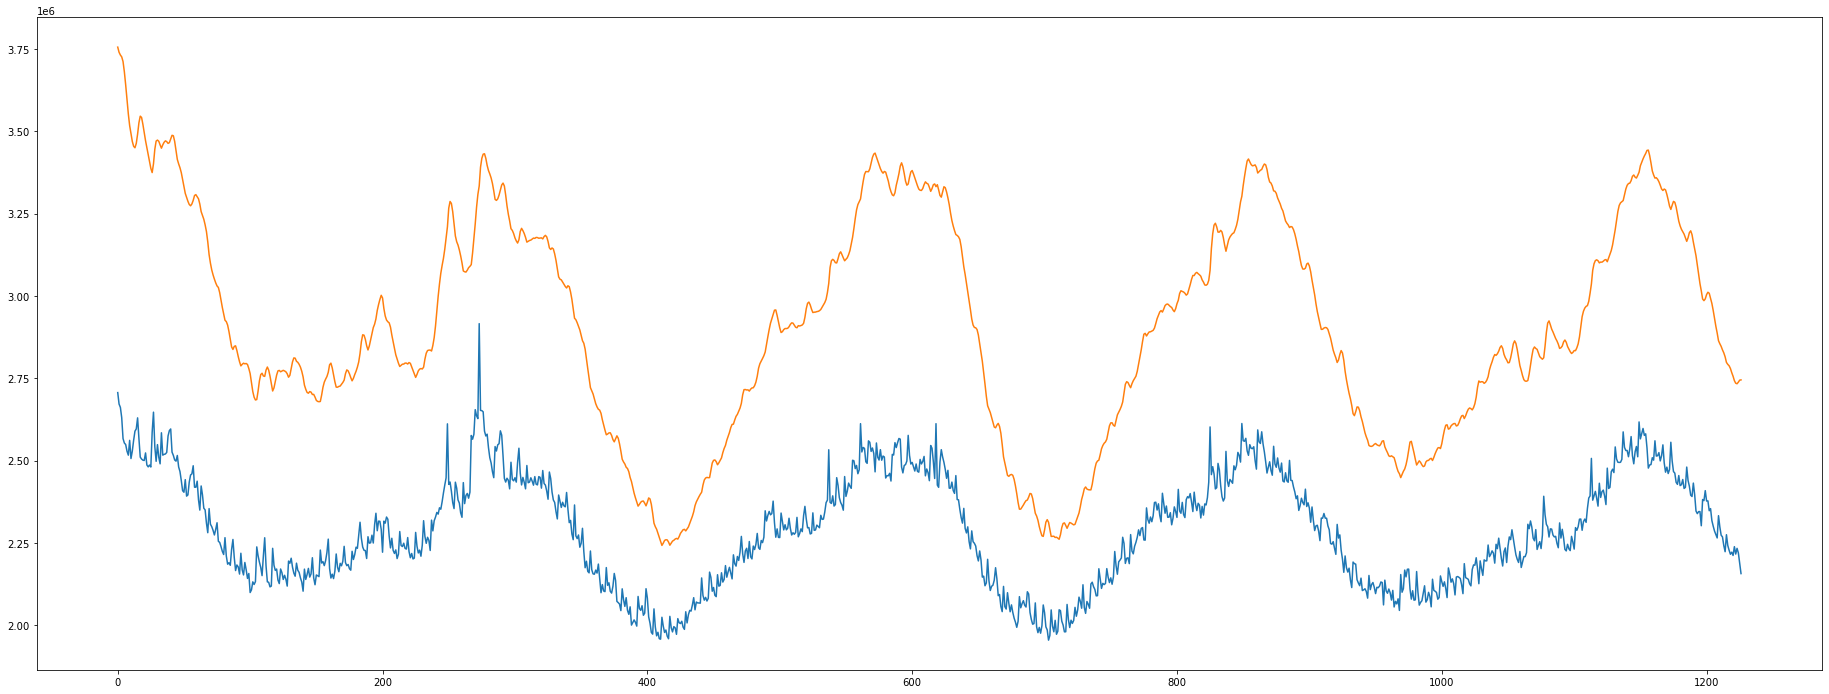

In [13]:
plot_max = plt.figure(1)
plt.plot(TestY['max_cpu'])
plt.plot(PredY['max_cpu'])
plt.show()

## Plot the Prediction of the Minimum CPU Usage

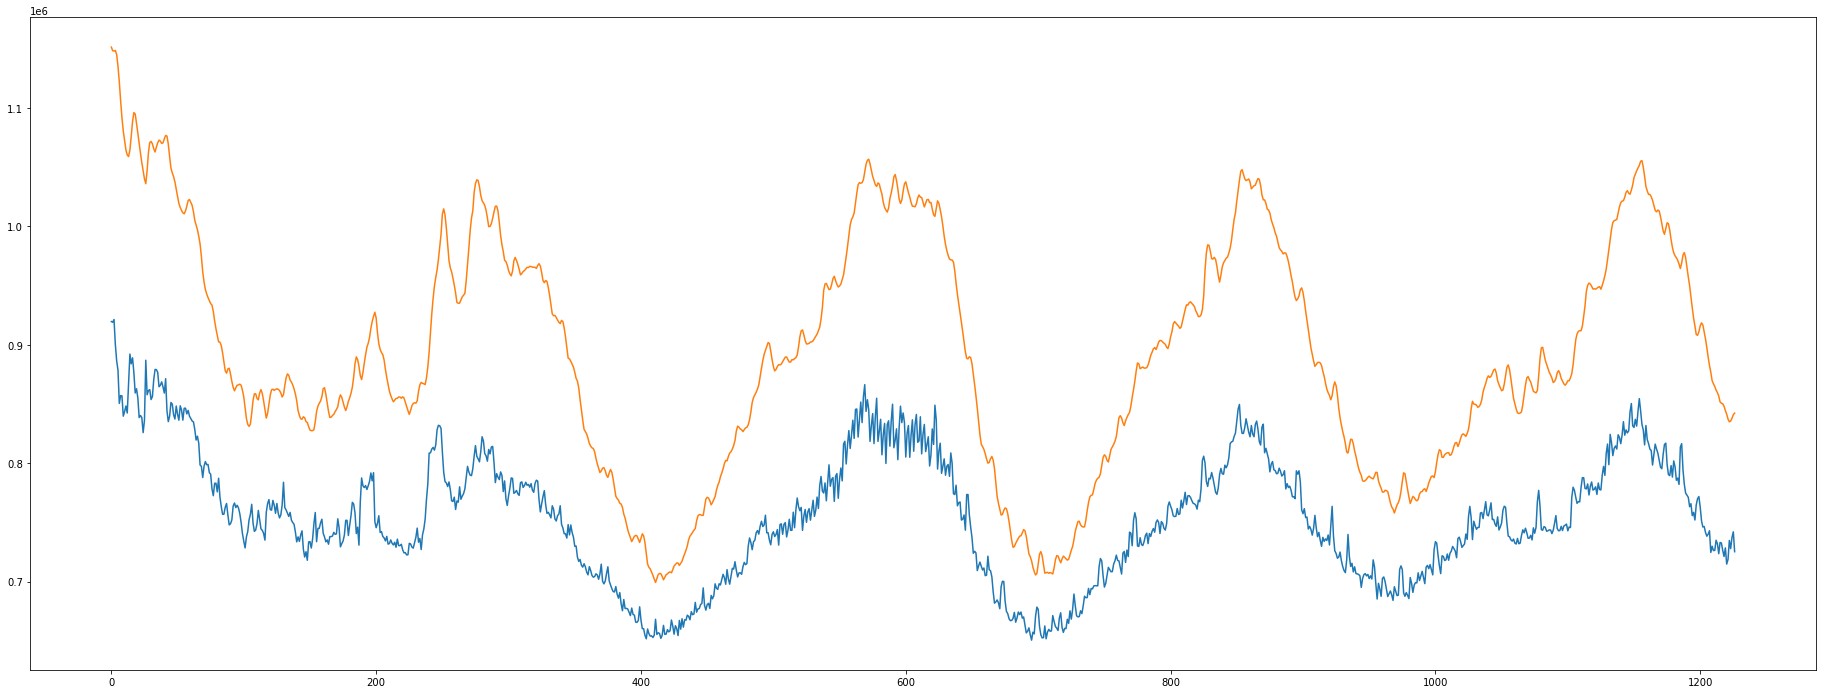

In [14]:
plot_min = plt.figure(2)
plt.plot(TestY['min_cpu'])
plt.plot(PredY['min_cpu'])
plt.show()

## Plot the Prediction of the Average CPU Usage

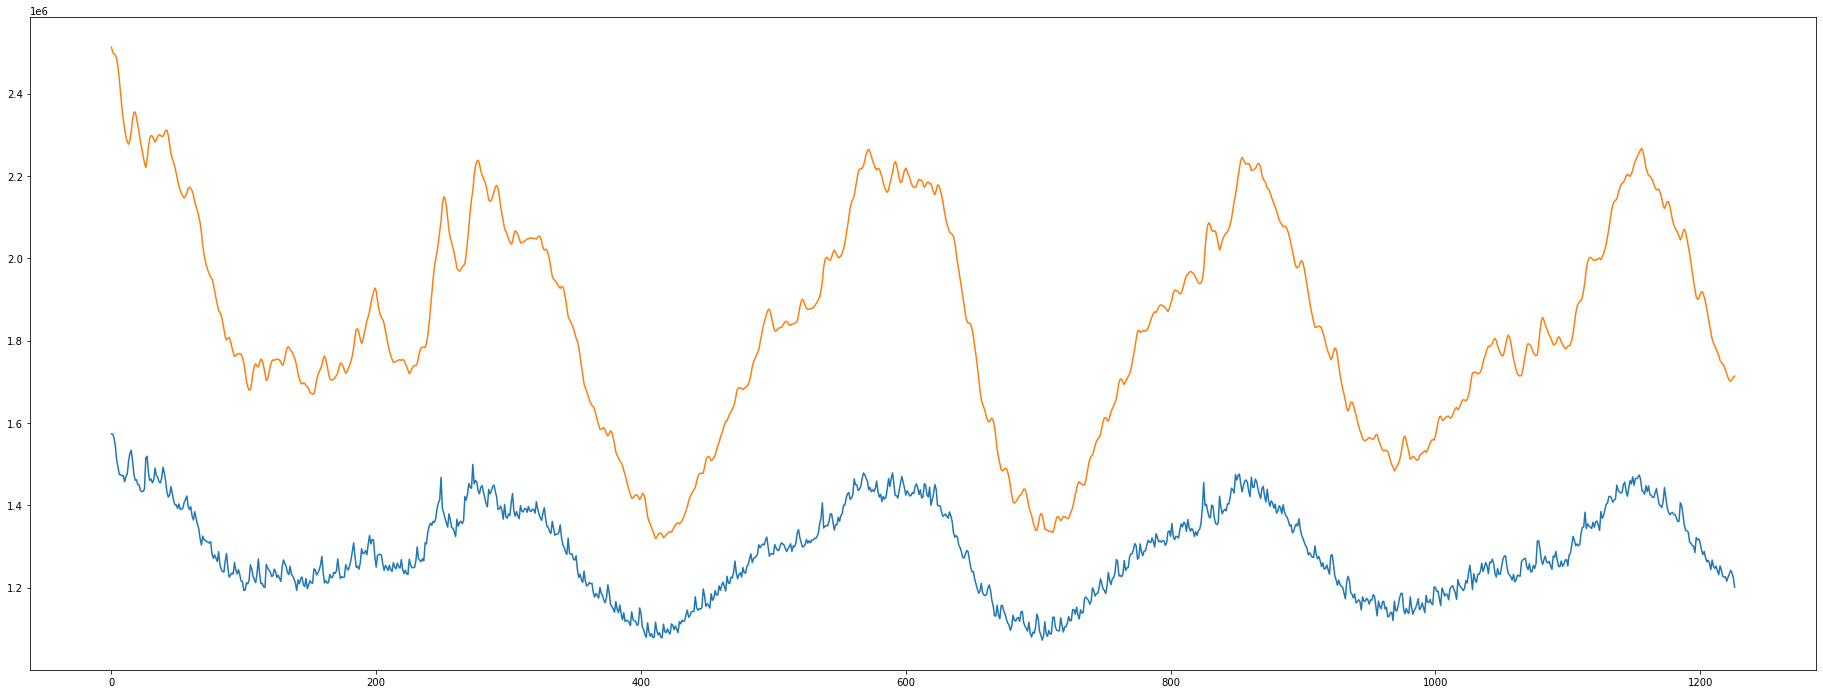

In [15]:
plot_avg = plt.figure(3)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

## Metrics of the ML Model Performance

### Root Mean Squared Error (RMSE)

$\operatorname{RMSD}(\hat{\theta}) = \sqrt{\operatorname{MSE}(\hat{\theta})} = \sqrt{\operatorname{E}((\hat{\theta}-\theta)^2)}$

In [18]:
rmse_result = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print(f'Test Score: {rmse_result:.2f} RMSE')

Test Score: 505838.30 RMSE


### Mean Absolute Error (MAE)

$\mathrm {MAE} ={\frac {\sum _{i=1}^{n}\left|y_{i}-x_{i}\right|}{n}}={\frac {\sum _{i=1}^{n}\left|e_{i}\right|}{n}}
$

In [19]:
mae_result = mean_absolute_error(y_test[:], preds[:])
print(f'Test Score: {mae_result} MAE')

Test Score: 436457.54402606684 MAE


### Mean Absolute Percentage Error (MAPE)

$MAPE={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|$

The **mean absolute percentage error (MAPE)**, is a measure of prediction accuracy of a forecasting (prediction) method in statistics.

$A_t$ is the actual value and $F_t$ is the predicted value. Their difference is divided by the actual value $A_t$. 

The absolute value in this ration is summed for every predicted point in time and divided by the number of fitted points $n$.

In [24]:
mape_result = np.mean(np.abs(y_test - preds)/np.abs(y_test)*100)
print(f'Test Score: {mape_result} MAPE')

Test Score: 28.964250296994237 MAPE
